In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, \
                         UpSampling2D, Input, Dense, Activation, Flatten, Reshape
from keras.utils import np_utils

from pandas import read_csv
from sklearn.model_selection import train_test_split

Using Theano backend.


In [3]:
dataset = read_csv('../datasets/mnist_data/train.csv')
dataset = dataset.values

In [4]:
X, y = dataset[:, 1:]/255, dataset[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
X_train, X_test = X_train.reshape((-1,28,28,1)), X_test.reshape((-1,28,28,1))
X_train.shape, X_test.shape

((33600, 28, 28, 1), (8400, 28, 28, 1))

In [27]:
e = 256

inp = Input(shape=(28,28,1))
conv1 = Conv2D(32, (3,3), activation='relu')(inp)
conv2 = Conv2D(16, (3,3), activation='relu')(conv1)
mp1   = MaxPool2D((2,2))(conv2)
conv3 = Conv2D(8, (3,3), activation='relu')(mp1)

flat = Flatten()(conv3)
emb = Dense(e, activation='sigmoid')(flat)
fc1 = Dense(800, activation='sigmoid')(emb)
res = Reshape((10,10,8))(fc1)

zp1 = ZeroPadding2D((1,1))(res)
conv4 = Conv2D(16, (3,3), padding='same', activation='relu')(zp1)
up1 = UpSampling2D((2,2))(conv4)
zp2 = ZeroPadding2D((1,1))(up1)
conv5 = Conv2D(32, (3,3), padding='same', activation='relu')(zp2)
zp3 = ZeroPadding2D((1,1))(conv5)
conv6 = Conv2D(1, (3,3), padding='same', activation='relu')(zp3)

cae = Model(inputs=inp, outputs=conv6)
cae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 10, 10, 8)         1160      
_________________________________________________________________
flatten_9 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               205056    
__________

In [50]:
cae.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [51]:
cae.layers

In [52]:
encoder = Model(inputs=inp, outputs=emb)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 10, 10, 8)         1160      
_________________________________________________________________
flatten_9 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               205056    
Total para

In [53]:
decoder_input = Input(shape=(e,))
dec_layer = cae.layers[7](decoder_input)

for i in range(8, len(cae.layers)):
    dec_layer = cae.layers[i](dec_layer)
decoder = Model(inputs=decoder_input, outputs=dec_layer)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 800)               205600    
_________________________________________________________________
reshape_6 (Reshape)          (None, 10, 10, 8)         0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 12, 12, 16)        1168      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 24, 24, 16)        0         
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 26, 26, 16)        0         
__________

In [54]:
hist = cae.fit(X_train, X_train,
        shuffle=True,
        epochs=10,
        validation_data=(X_test, X_test),
        batch_size=512
       )

Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 115s 3ms/step - loss: 0.0128 - acc: 0.8128 - val_loss: 0.0066 - val_acc: 0.8145
Epoch 2/10
33600/33600 [==============================] - 124s 4ms/step - loss: 0.0061 - acc: 0.8147 - val_loss: 0.0059 - val_acc: 0.8147
Epoch 3/10
33600/33600 [==============================] - 113s 3ms/step - loss: 0.0056 - acc: 0.8148 - val_loss: 0.0055 - val_acc: 0.8148
Epoch 4/10
33600/33600 [==============================] - 113s 3ms/step - loss: 0.0052 - acc: 0.8148 - val_loss: 0.0051 - val_acc: 0.8148
Epoch 5/10
33600/33600 [==============================] - 112s 3ms/step - loss: 0.0048 - acc: 0.8149 - val_loss: 0.0047 - val_acc: 0.8149
Epoch 6/10
33600/33600 [==============================] - 113s 3ms/step - loss: 0.0045 - acc: 0.8149 - val_loss: 0.0045 - val_acc: 0.8149
Epoch 7/10
33600/33600 [==============================] - 113s 3ms/step - loss: 0.0044 - acc: 0.8149 - val_loss: 0.0043 - v

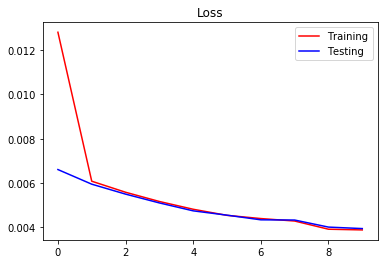

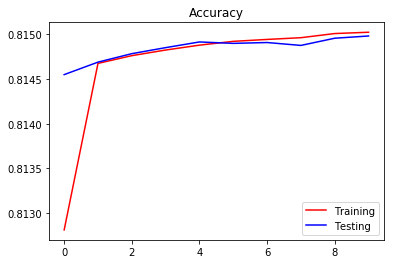

In [55]:
plt.figure(0)
plt.title("Loss")
plt.plot(hist.history['loss'], 'r', label='Training')
plt.plot(hist.history['val_loss'], 'b', label='Testing')
plt.legend()
plt.show()

plt.figure(1)
plt.title("Accuracy")
plt.plot(hist.history['acc'], 'r', label='Training')
plt.plot(hist.history['val_acc'], 'b', label='Testing')
plt.legend()
plt.show()

In [56]:
test = X_train[:20]
preds = cae.predict(test)
print(test.shape, preds.shape)

(20, 28, 28, 1) (20, 28, 28, 1)


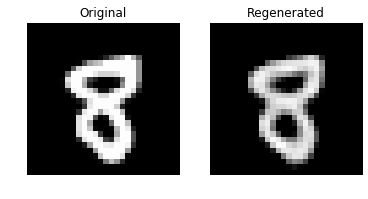

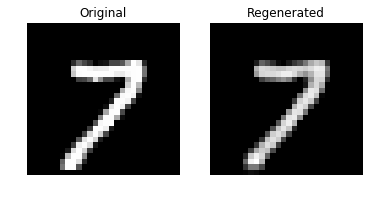

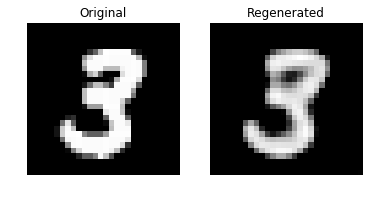

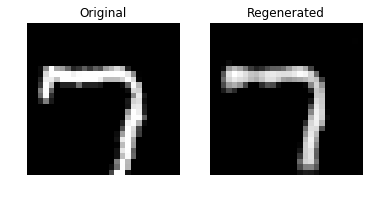

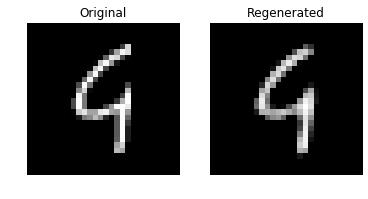

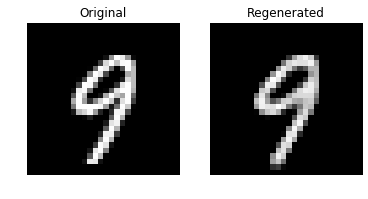

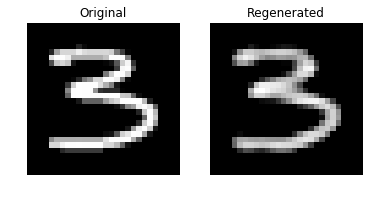

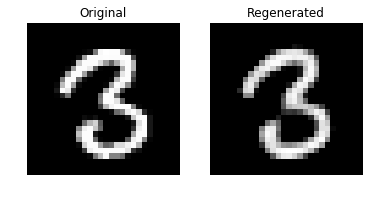

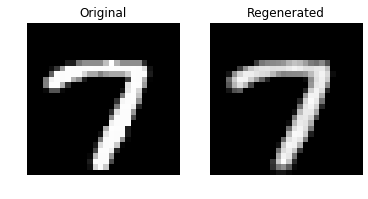

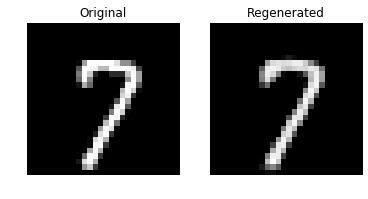

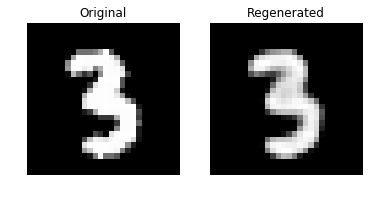

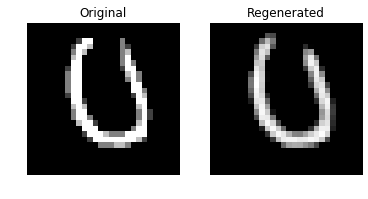

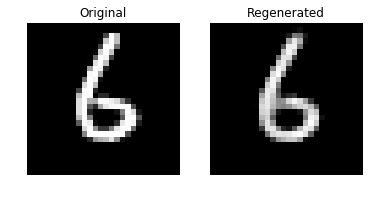

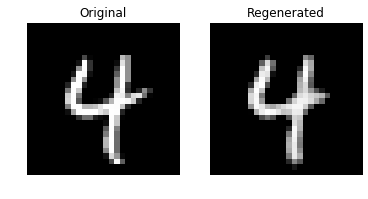

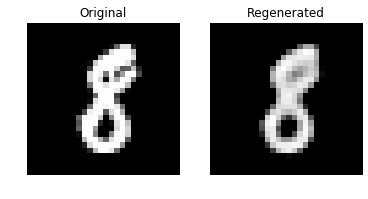

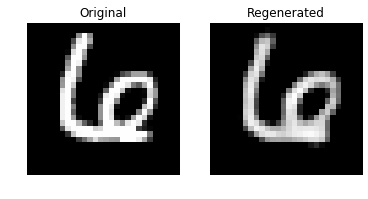

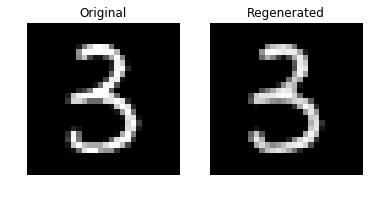

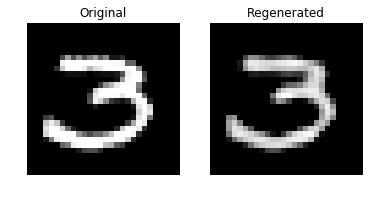

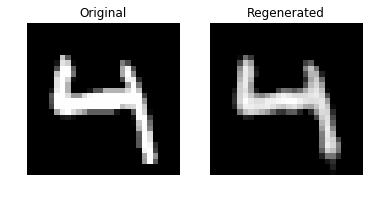

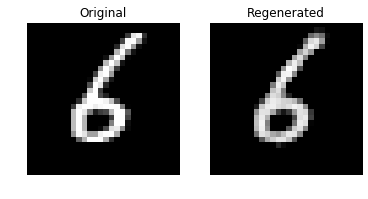

In [57]:
for i in range(test.shape[0]):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(test[i].reshape((28,28)), cmap='gray')
    
    plt.subplot(1,2,2)
    plt.title('Regenerated')
    plt.axis('off')
    plt.imshow(preds[i].reshape((28,28)), cmap='gray')